In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2 as cv
import os
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator

2023-08-13 13:55:57.642207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = 'samples'
imgs = os.listdir(path)

In [18]:
imm = imgs[0]
imm = cv.imread(os.path.join(path , imm ), cv.IMREAD_GRAYSCALE )

print(imm.dtype)   
print(imm.ndim)    
print(imm.shape) 

uint8
2
(50, 200)


In [118]:
X = []
y = []
img_name = ''
count =0
for img in imgs:
    if img[5:] != '.png':
        continue
    
    count+=1
    image_name = img
    img = cv.imread(os.path.join(path , img ), cv.IMREAD_GRAYSCALE )
    img = cv.adaptiveThreshold(img , 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C ,cv.THRESH_BINARY , 11 , 2 )
    kernel = np.ones((2,2),np.uint8)
    img = cv.medianBlur(img,3)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    
#     img = cv.dilate(img,kernel,iterations = 1)
#     img = cv.bilateralFilter(img,9,75,75)
    img = cv.GaussianBlur(img,(1,1),0)
    img = cv.cvtColor(img , cv.COLOR_BGR2RGB)
    x=[img[10:50,30:50],img[10:50,55:75],
                 img[10:50,75:95],img[10:50,100:120],img[10:50,120:140]] 
    for i in range(5):
        X.append(img_to_array(Image.fromarray(x[i])))
        y.append(image_name.split('.')[0][i])
      
    
   


In [119]:
X = np.array(X)
y = np.array(y)

In [120]:
X=X.astype('float32')
X/=255

[]

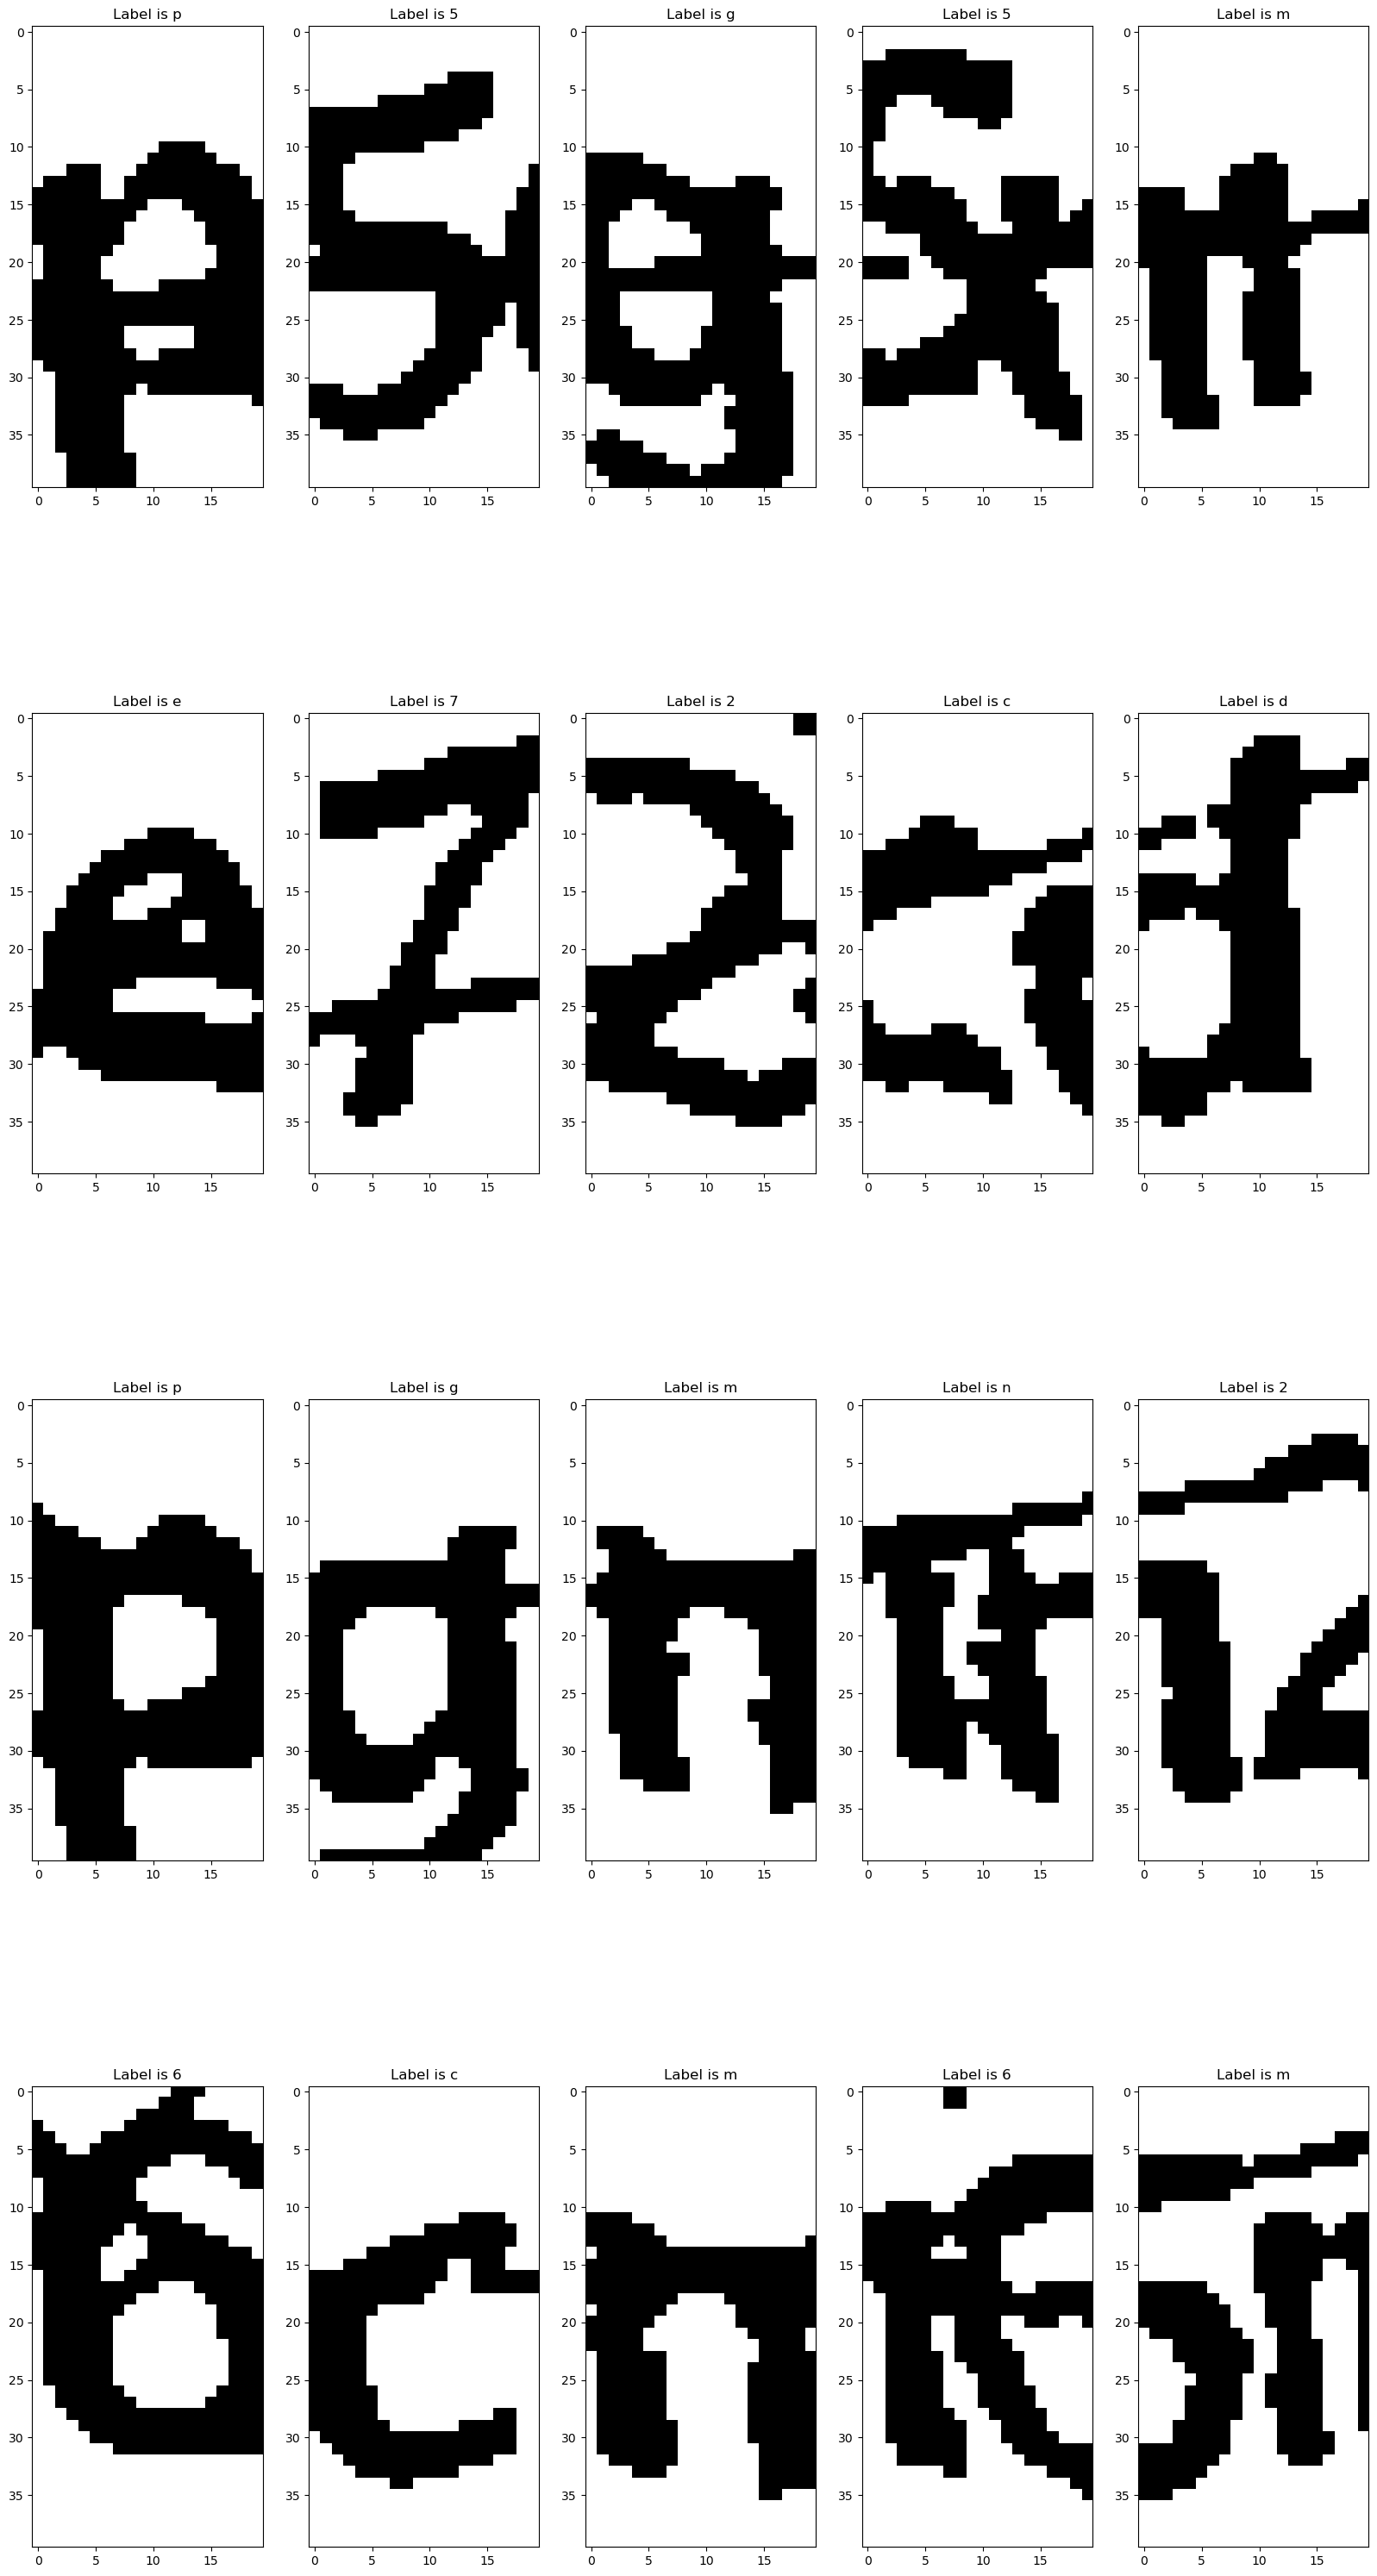

In [121]:
plt.figure(figsize = (20,50))
for i in range(20) :
    plt.subplot(5,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.title('Label is ' + str(y[i]))
plt.plot()

In [122]:
print(X[0].dtype)   
print(X[0].ndim)    
print(X[0].shape) 

float32
3
(40, 20, 3)


In [123]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

/Users/lakhanbhansali/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [124]:
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense,InputLayer
model = Sequential()

model.add(InputLayer(input_shape=(row,col,3)))
model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))



model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 40, 20, 16)        448       
                                                                 
 activation_84 (Activation)  (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 20, 10, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 20, 10, 16)        2320      
                                                                 
 activation_85 (Activation)  (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 10, 5, 16)         0         
 ng2D)                                               

In [125]:
batch_size = 150
epochs = 200

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

Epoch 1/200
28/28 [==============================] - 2s 48ms/step - loss: 2.9041 - accuracy: 0.0957 - val_loss: 2.7845 - val_accuracy: 0.1038
Epoch 2/200
28/28 [==============================] - 1s 48ms/step - loss: 2.3452 - accuracy: 0.2632 - val_loss: 1.6423 - val_accuracy: 0.5154
Epoch 3/200
28/28 [==============================] - 1s 53ms/step - loss: 1.5646 - accuracy: 0.5163 - val_loss: 1.0909 - val_accuracy: 0.6942
Epoch 4/200
28/28 [==============================] - 1s 42ms/step - loss: 1.1839 - accuracy: 0.6317 - val_loss: 0.8096 - val_accuracy: 0.7692
Epoch 5/200
28/28 [==============================] - 1s 52ms/step - loss: 0.9861 - accuracy: 0.6990 - val_loss: 0.7219 - val_accuracy: 0.7904
Epoch 6/200
28/28 [==============================] - 1s 42ms/step - loss: 0.8272 - accuracy: 0.7517 - val_loss: 0.6506 - val_accuracy: 0.8010
Epoch 7/200
28/28 [==============================] - 1s 39ms/step - loss: 0.7338 - accuracy: 0.7659 - val_loss: 0.5525 - val_accuracy: 0.8317
Epoch 

28/28 [==============================] - 1s 39ms/step - loss: 0.1499 - accuracy: 0.9486 - val_loss: 0.2764 - val_accuracy: 0.9375
Epoch 59/200
28/28 [==============================] - 1s 39ms/step - loss: 0.1318 - accuracy: 0.9550 - val_loss: 0.2889 - val_accuracy: 0.9308
Epoch 60/200
28/28 [==============================] - 1s 39ms/step - loss: 0.1141 - accuracy: 0.9560 - val_loss: 0.2637 - val_accuracy: 0.9337
Epoch 61/200
28/28 [==============================] - 1s 39ms/step - loss: 0.1135 - accuracy: 0.9563 - val_loss: 0.3686 - val_accuracy: 0.9135
Epoch 62/200
28/28 [==============================] - 1s 39ms/step - loss: 0.1265 - accuracy: 0.9555 - val_loss: 0.2972 - val_accuracy: 0.9346
Epoch 63/200
28/28 [==============================] - 1s 40ms/step - loss: 0.1280 - accuracy: 0.9565 - val_loss: 0.2866 - val_accuracy: 0.9308
Epoch 64/200
28/28 [==============================] - 1s 39ms/step - loss: 0.1223 - accuracy: 0.9565 - val_loss: 0.3037 - val_accuracy: 0.9279
Epoch 65/200

28/28 [==============================] - 1s 40ms/step - loss: 0.0691 - accuracy: 0.9767 - val_loss: 0.3390 - val_accuracy: 0.9212
Epoch 116/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0701 - accuracy: 0.9745 - val_loss: 0.3367 - val_accuracy: 0.9279
Epoch 117/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0691 - accuracy: 0.9745 - val_loss: 0.3569 - val_accuracy: 0.9279
Epoch 118/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0622 - accuracy: 0.9767 - val_loss: 0.3000 - val_accuracy: 0.9356
Epoch 119/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0684 - accuracy: 0.9752 - val_loss: 0.3326 - val_accuracy: 0.9279
Epoch 120/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0644 - accuracy: 0.9781 - val_loss: 0.3325 - val_accuracy: 0.9288
Epoch 121/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0568 - accuracy: 0.9788 - val_loss: 0.3055 - val_accuracy: 0.9413
Epoch 

Epoch 172/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0561 - accuracy: 0.9832 - val_loss: 0.3290 - val_accuracy: 0.9365
Epoch 173/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0557 - accuracy: 0.9810 - val_loss: 0.3649 - val_accuracy: 0.9317
Epoch 174/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0530 - accuracy: 0.9805 - val_loss: 0.3418 - val_accuracy: 0.9337
Epoch 175/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0526 - accuracy: 0.9791 - val_loss: 0.3426 - val_accuracy: 0.9375
Epoch 176/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0621 - accuracy: 0.9776 - val_loss: 0.3189 - val_accuracy: 0.9365
Epoch 177/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0442 - accuracy: 0.9844 - val_loss: 0.3390 - val_accuracy: 0.9356
Epoch 178/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0521 - accuracy: 0.9825 - val_loss: 0.3533 - val_accuracy:

In [126]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

33/33 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.9385
Test loss: 0.36648812890052795
Test accuracy: 0.9384615421295166
